# FOCUS COMMERCANTS

Objectif : utiliser l'ACP pour faire un focus sur la thématique des commerces/commerçants dans les tweets de la requête francophone cash et cb.

In [1]:
# Librairies 
from collections import Counter
import pprint
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from nltk.corpus import stopwords
import numpy as np
from gensim.models.phrases import Phrases
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
import pandas as pd
import preprocessor as p
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import tqdm
from wordcloud import WordCloud
import os

pd.set_option("max_colwidth", None)
SAVE_FIG = True 
path = os.chdir("/home/cash")
FIGSIZE = (12, 7)

In [37]:
# Fonctions 
def make_query(what, how):
    return " OR ".join(what) + " AND " + " OR ".join(how)

class TweetCorpus(object):
    """An interator that yields sentences (lists of str)."""
    threshold = 0
    
    def __iter__(self):
        for tweet in df.clean_tweet:
            # assume there's one document per line, tokens separated by whitespace
            tweet = [w for w in tweet.split() if w not in swfr]
            tweet = phrase_model[tweet]
            yield tweet

            def plot_pca_var(pca_values, i, j, feature_names, zoom=1):
    fig = plt.figure(figsize=(10,10))
    
    ax1, ax2 = pca_values[[i, j]]
    plt.quiver(
        np.zeros(len(ax1)), np.zeros(len(ax1)), ax1, ax2, 
        angles='xy', scale_units='xy', scale=1, alpha=.25, width=1/500)

    # Add labels based on feature names (here just numbers)
    for x, y, txt in zip(ax1, ax2, feature_names):
        alpha = (x**2+y**2)*200
        jitter_x, jitter_y = np.random.normal(scale=1/10, size=2)
        plt.text(x+jitter_x, y+jitter_y, txt, ha='center', va='center', alpha=.8, size=8)

    # Add unit circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)

    # Ensure correct aspect ratio and axis limits
    plt.axis('equal')
    plt.xlim([-1.05/zoom,1.05/zoom])
    plt.ylim([-1.05/zoom,1.05/zoom])

    # Label axes
    plt.xlabel(f'PC {i}')
    plt.ylabel(f'PC {j}')
    plt.axhline(0, alpha=.5, color="gray", linestyle="--")
    plt.axvline(0, alpha=.5, color="gray", linestyle="--")
    
    if SAVE_FIG:
        plt.savefig("figs/analyse_fr_stable/commercants_acp_axe" + str(i) + str(j) +".png")

    return fig

    # Done
    #plt.show()

#def encode_commercant(string, pattern="commer(c|ç)ants?"):
#    return re.sub(pattern=pattern, repl="COVID19", string=string)


IndentationError: expected an indented block (<ipython-input-37-e28652005152>, line 17)

In [24]:
# Import data 
df_cash = pd.read_pickle("/home/cash/output/cleaned_queries/with_geoloc/query_fr_cash_cleaned_geoloc.pickle")
df_cb = pd.read_pickle("/home/cash/output/cleaned_queries/with_geoloc/query_fr_cb_cleaned_geoloc.pickle")
df = df_cash.assign(query="cash").append(df_cb.assign(query="cb"))

# Import modele 
model = Word2Vec.load("/home/cash/output/word2vec_models/word2vec_s200_ngram_w5_mc10_ALL.model")

# Définir mots clés de la requête 
WHAT_CASH = ['espece',  'especes', 'billets', 'billet', 'piece', 'pieces', 'monnaie', 'cash',
             'liquide', 'retraits', 'retrait', 'distributeur', 'distributeurs', '" DAB "', 'guichet', 'guichets'
            ]
HOW_CASH = ['paiement', 'paiements', 'payer', 'reglements', 'reglement', 'regler', 'achat',
            'achats', 'acheter', 'retirer', 'depenser', 'depense', 'depenses']
WHAT_CB = ['carte', 'cartes', '" CB "', '"sans contact"', '" visa "', 'mastercard',
            '"cash back"', '" NFC "', '"Google Pay"', '"ApplePay"', '"Paylib"', '"Lydia"',
            '"Lyf Pay"', '"Alipay"', '"Samsung Pay"', '"Stocard Pay"', '"paiements mobiles"', '"chèques"']
HOW_CB = ['paiement', 'paiements', 'payer', 'reglement', 'reglements', 'regler','achat', 'achats',
          'acheter', 'retirer', 'virement', 'virements', 'virer', 'depenser', 'depense', 'depenses']
QUERIES = dict(query_fr_cash = make_query(WHAT_CASH, HOW_CASH),
               query_fr_cb = make_query(WHAT_CB, HOW_CB))

# Import et rajouts de stopwords 
more_swfr = set([
    "si", "ça", "tout", "peut", "plus", "cb", "va", "être", "oui", "non", "mai", "quand", "chez", "car",
    "aussi", "cet", "cette", "ce", "ca", "donc", "comme", "jusqu", "pendant", "avoir", "pq", "là", "lui", "moi",
    "dit", "dis", "tous", "toutes", "trop", "vu", "viens", "quoi", "quel", "pr",  "bah", "amp", "ah", "encore",
    "juste", "après", "rien", "a", "où", "moins", "déjà", "avant", "très", "ceux", "celles", "ces", "leur", 
    "leurs", "dès", "selon", "elle", "elles", "autres", "près", "vers", "afin", "ainsi", "peux", "aller", 
    "vient", "fait", "faut", "faire", "vont", "viennent",
])
swfr = set(stopwords.words('french')) | more_swfr

### Process data

In [26]:
# Ajouts de colonnes
print("Add cols")
df["datetime"] = pd.to_datetime(df.date.astype(str) + " " + df.time.astype(str), errors="coerce")
df["index"] = df["datetime"]
df.set_index("index", inplace=True)

# Cleaning résiduel de la variable clean_tweet
df["clean_tweet"] = df.clean_tweet.apply(lambda s: re.sub(pattern="[0-9]", repl="", string=s))
df["clean_tweet"] = df.clean_tweet.apply(lambda tweet: tweet.replace("-",  " ").replace("#", ""))

# Train ngrams
phrase_model = Phrases(df.clean_tweet.apply(str.split).tolist(), min_count=10, threshold=20, common_terms=swfr)
%%time
df["clean_tweet_ngram"] = df.clean_tweet.apply(lambda tweet: " ".join(phrase_model[tweet.split()]))

Add cols


UsageError: Line magic function `%%time` not found.


### Définir les termes relatifs à commerçants qui vont être étudiés ensuite

In [27]:
corpus = TweetCorpus()

In [28]:
# Définir les termes relatifs à "commerçants"
COMMERCANT_strict = [
    "commercant", "commercants", "commerçant", "commerçants", "commerce", "commerces", "boulangerie", "boulangeries"
]
wv_df = pd.concat([
    pd.DataFrame(model.wv.most_similar(word), columns=["associated_word", "similarity"]).assign(word=word) for word in COMMERCANT_strict
])
print(wv_df)
print(model.wv.most_similar("commercant"))

# Elargir cette liste en prenant les mots proches des termes de COMMERCANT_strict dans l'espace de Word2vec (cosine similarité) : 
# --> COMMERCANT_extended
COMMERCANT_extended = wv_df.loc[lambda df: df.similarity > .70, "associated_word"].drop_duplicates().tolist()
print(COMMERCANT_extended)
wv_df_pretty = wv_df.groupby("word").associated_word.apply(lambda s: ", ".join(s)).reset_index()
wv_df_pretty.to_html("figs/analyse_fr_stable/words_commercants.html", index=False)

     associated_word  similarity          word
0    brève_lexisactu    0.806658    commercant
1           esntrôlé    0.794916    commercant
2       somme_exacte    0.790984    commercant
3             rungis    0.786552    commercant
4             rédigé    0.783757    commercant
..               ...         ...           ...
5         boulangers    0.712360  boulangeries
6   petits_commerces    0.697703  boulangeries
7           claviers    0.696727  boulangeries
8           microbes    0.694754  boulangeries
9           baladent    0.681504  boulangeries

[80 rows x 3 columns]
[('brève_lexisactu', 0.806657612323761), ('esntrôlé', 0.7949157953262329), ('somme_exacte', 0.7909837961196899), ('rungis', 0.7865518927574158), ('rédigé', 0.7837566137313843), ('fixant', 0.7827582359313965), ('jordan_authentique', 0.7797843813896179), ('changerait', 0.7772210240364075), ('radio_skyrock', 0.7769464254379272), ('apposé', 0.7767595648765564)]
['brève_lexisactu', 'esntrôlé', 'somme_exacte', 'rung

<AxesSubplot:xlabel='index'>

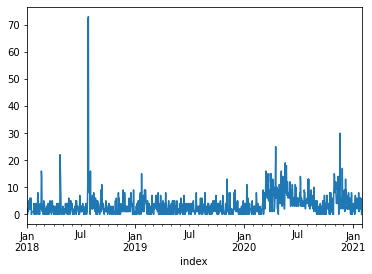

In [30]:
# Comptage des tweets qui ont au moins un des mots clés de COMMERCANT_strict
df["mask_commercant"] = df.clean_tweet.str.count(" | ".join(COMMERCANT_strict))
df.mask_commercant.resample("D").sum().plot()

100%|██████████| 48/48 [00:11<00:00,  4.23it/s]


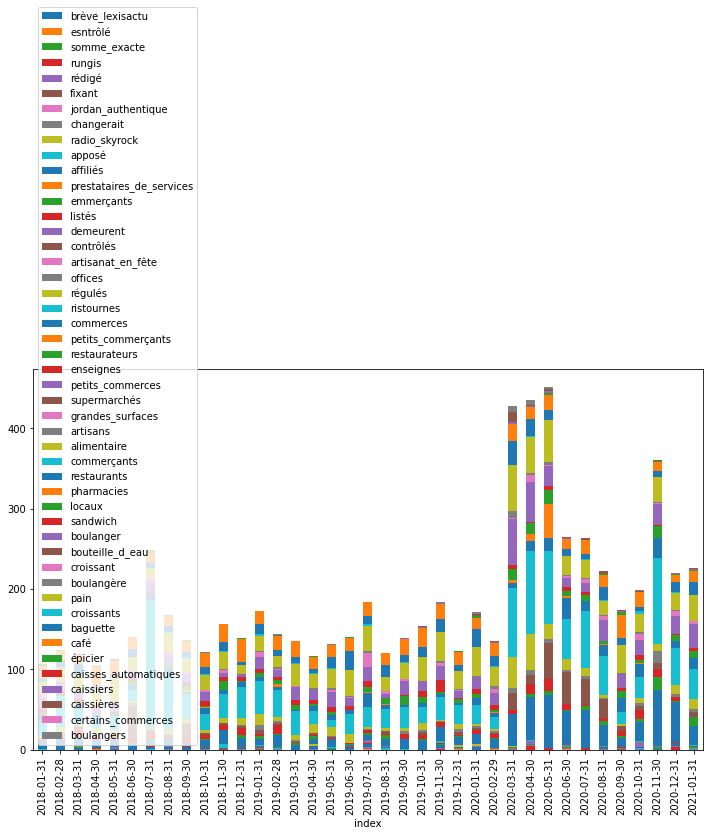

In [31]:
# Comptage des tweets par présence de mots-clés de COMMERCANT_extended
count_commercant_words = pd.DataFrame({
    word: df.clean_tweet.str.count(word) for word in tqdm.tqdm(COMMERCANT_extended)
})

f, ax = plt.subplots(figsize=FIGSIZE)
count_commercant_words.resample("M").sum().plot.bar(stacked=True, ax=ax)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
labels = [item.get_text().split()[0] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.show()

### L'ACP sur le comptage hebdomadaire des termes de COMMERCANT_extended

In [33]:
X = count_commercant_words.resample("W").sum()
X = X.apply(lambda x: (x - x.mean())/x.std(), axis=1).to_numpy()
pca = PCA(n_components=3)
indiv_pca = pca.fit_transform(X)

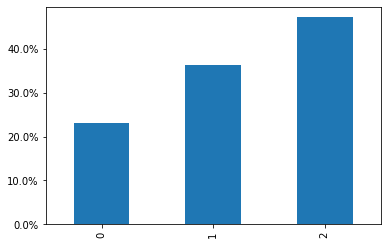

In [34]:
ax = pd.Series(pca.explained_variance_ratio_).cumsum().plot(kind="bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [35]:
def plot_pca_var(pca_values, i, j, feature_names, zoom=1):
    fig = plt.figure(figsize=(10,10))
    
    ax1, ax2 = pca_values[[i, j]]
    plt.quiver(
        np.zeros(len(ax1)), np.zeros(len(ax1)), ax1, ax2, 
        angles='xy', scale_units='xy', scale=1, alpha=.25, width=1/500)

    # Add labels based on feature names (here just numbers)
    for x, y, txt in zip(ax1, ax2, feature_names):
        alpha = (x**2+y**2)*200
        jitter_x, jitter_y = np.random.normal(scale=1/10, size=2)
        plt.text(x+jitter_x, y+jitter_y, txt, ha='center', va='center', alpha=.8, size=8)

    # Add unit circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
    plt.gca().add_artist(circle)

    # Ensure correct aspect ratio and axis limits
    plt.axis('equal')
    plt.xlim([-1.05/zoom,1.05/zoom])
    plt.ylim([-1.05/zoom,1.05/zoom])

    # Label axes
    plt.xlabel(f'PC {i}')
    plt.ylabel(f'PC {j}')
    plt.axhline(0, alpha=.5, color="gray", linestyle="--")
    plt.axvline(0, alpha=.5, color="gray", linestyle="--")
    
    if SAVE_FIG:
        plt.savefig("figs/analyse_fr_stable/commercants_acp_axe" + str(i) + str(j) +".png")

    return fig

    # Done
    #plt.show()
    
    

    

In [232]:
import matplotlib.pyplot as plt

In [36]:
fig.show()

NameError: name 'fig' is not defined

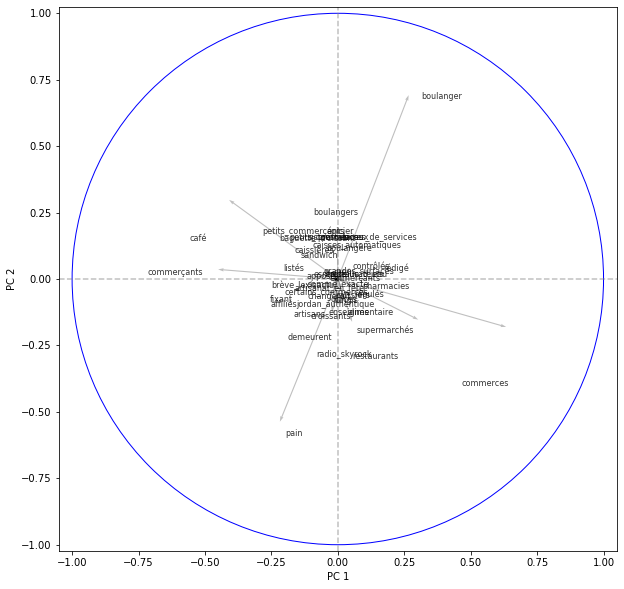

In [38]:
zoom = 1
axe_1 = 1
axe_2 = 2
fig = plot_pca_var(pca.components_, axe_1, axe_2, feature_names = count_commercant_words.columns, zoom=zoom)

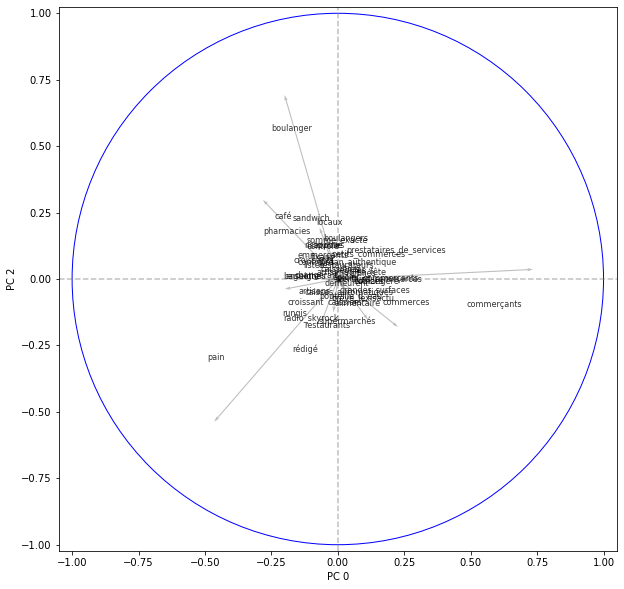

In [39]:
zoom = 1
axe_1 = 0
axe_2 = 2
fig = plot_pca_var(pca.components_, axe_1, axe_2, feature_names = count_commercant_words.columns, zoom=zoom)

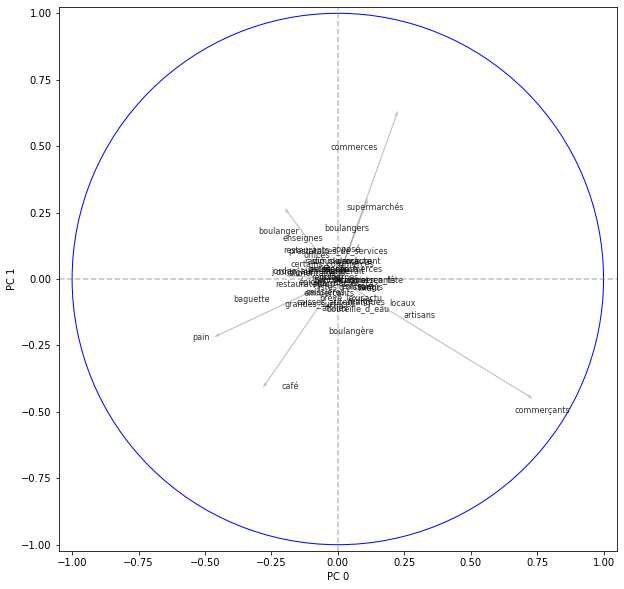

In [40]:
zoom = 1
axe_1 = 0
axe_2 = 1
fig = plot_pca_var(pca.components_, axe_1, axe_2, feature_names = count_commercant_words.columns, zoom=zoom)

<AxesSubplot:xlabel='index'>

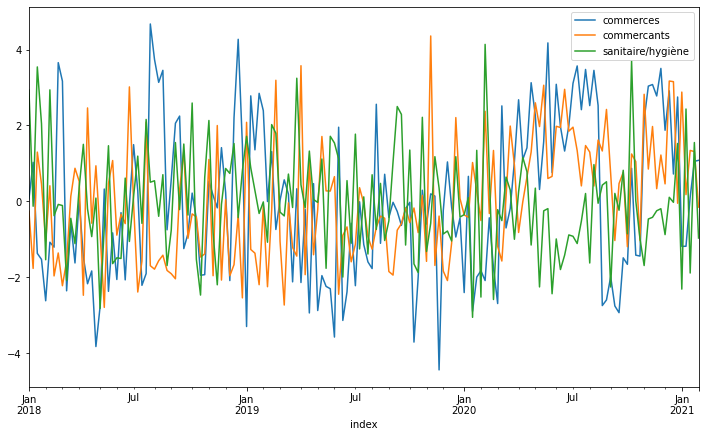

In [41]:
acp_axes_df = pd.DataFrame(indiv_pca, index=count_commercant_words.resample("W").sum().index, columns=["commerces", "commercants", "sanitaire/hygiène"])
acp_axes_df.plot(figsize=FIGSIZE)

## Focus commercants - évènement juillet 2018

L'analyse de l'ACP a montré que la fréquence d'utilisation des termes commerçants et commerces avait des patterns assez différents, alors que ces termes relèvent pourtant du même champ lexical. 
Nous avons donc regardé le comptage de tweets qui mentionnent ces deux termes au cours du temps. 

/home/cash/.local/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


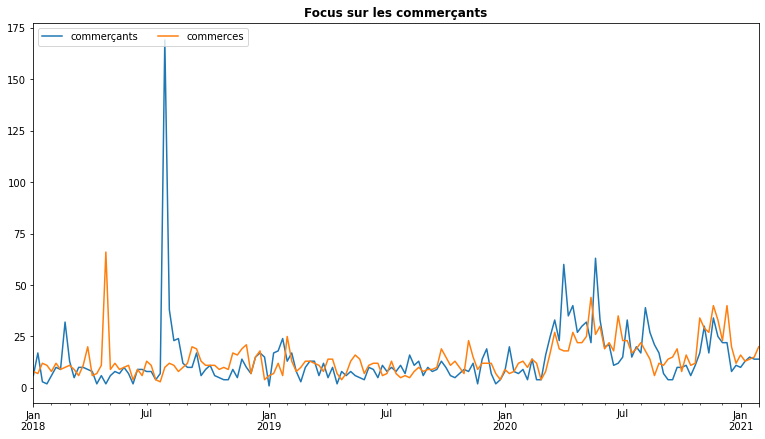

In [42]:
comm_1 = df.clean_tweet.str.contains("commer(c|ç)ants?").resample("W").sum()
comm_2 = df.clean_tweet.str.contains("commerces?").resample("W").sum()

ax = comm_1.plot(figsize=(13, 7), label = "commerçants")
ax = comm_2.plot(figsize=(13, 7), label= "commerces")

ax.set_title("Focus sur les commerçants", fontweight="bold")
ax.set_xlabel("")
ax.legend(ncol=2, loc="upper left")

if SAVE_FIG:
        ax.figure.savefig("output/figs/focus_commercant/focus_comm.png")
# On constate un évènement en juillet 2018 : surtout pour le mot clé commerçants

In [105]:
# En regardant dans les tweets à cette période, on comprend qu'une nouvelle réglementation ("le cash back") a été autorisé à cette période 
# et explique cette hausse soudaine de tweets sur les commerçants. Le terme "commerces" n'est en pratique pas utilisé pour parler de ça. 
# cashback : payer une somme plus importante par cb et récupérer le sur plus sous formes d'espèces 
# = revient à pouvoir en france retirer des espèces chez commerçants. 
df[df.clean_tweet.str.contains("commer(c|ç)ants?")].loc["2018-08"].clean_tweet[1:50]

/home/cash/.local/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


index
2018-08-14 17:33:16                                     retirer de l argent sera bientôt possible chez les commerçants  il suffira de payer par carte un montant supérieur et le surplus vous sera rendu directement en espèces  l essor des paiements digitaux pourrait mener à une société sans argent liquide d ici  ans  cashback
2018-08-27 13:42:20                                                                                         en france  le montant moyen d un paiement en espèces est de   euros les français continuent de régler en pièces et billets les achats de faible montant chez les commerçants  @banquedefrance   ///pjsmqlpuw   ///kgnfueh
2018-08-05 09:39:59                                                je cherche encore l intérêt du casgback ! si le commerçant a un terminal de paiement  pourquoi avoir besoin de monnaie ? en zone rurale  il faut le trouver le commerçant qui a un terminal de paiement (ça coûte cher en frais d accepter le paiement par carte) 
2018-08-06 09:45

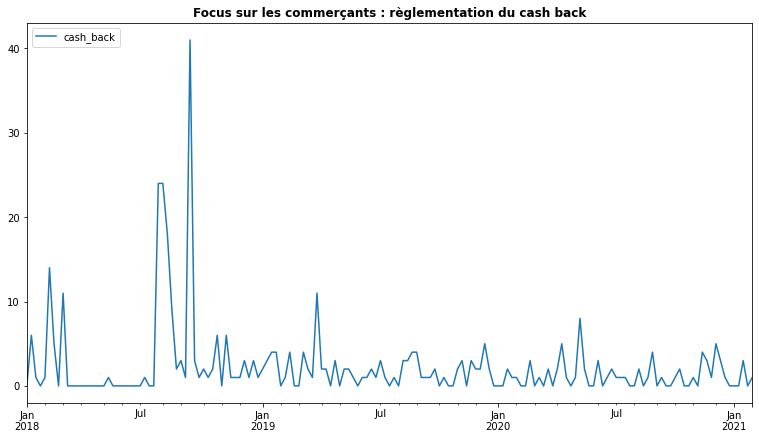

In [43]:
cash_back= df.clean_tweet.str.count("cash_back|cash back").resample("W").sum()
ax = cash_back.plot(figsize=(13, 7), label = "cash_back")

ax.set_title("Focus sur les commerçants : règlementation du cash back", fontweight="bold")
ax.set_xlabel("")
ax.legend(ncol=2, loc="upper left")

if SAVE_FIG:
        ax.figure.savefig("output/figs/focus_commercant/focus_cash_back.png")